<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [28]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (3).csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


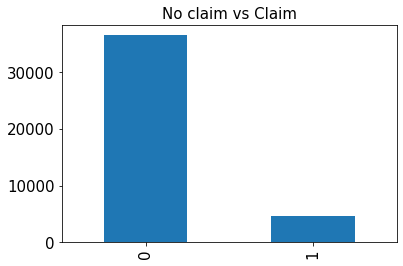

In [29]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

Check if rows missing

In [33]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

Transform numerical data

In [39]:
print(df.pdays.unique())

[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


   age        job  marital  ... euribor3m_log emp.var.rate_log cons.price.idx_log
0   56  housemaid  married  ...      1.580421          0.09531           4.543231
1   57   services  married  ...      1.580421          0.09531           4.543231
2   37   services  married  ...      1.580421          0.09531           4.543231
3   40     admin.  married  ...      1.580421          0.09531           4.543231
4   56   services  married  ...      1.580421          0.09531           4.543231

[5 rows x 20 columns]


target
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

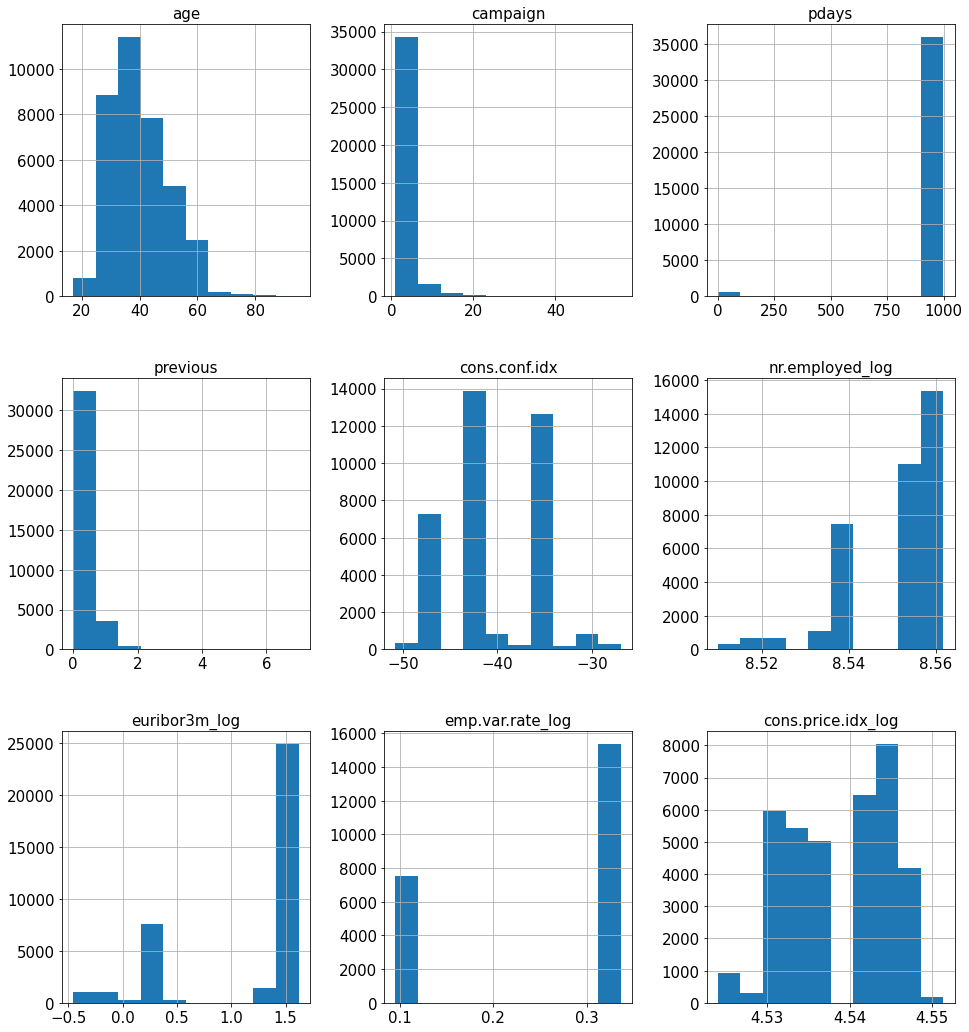

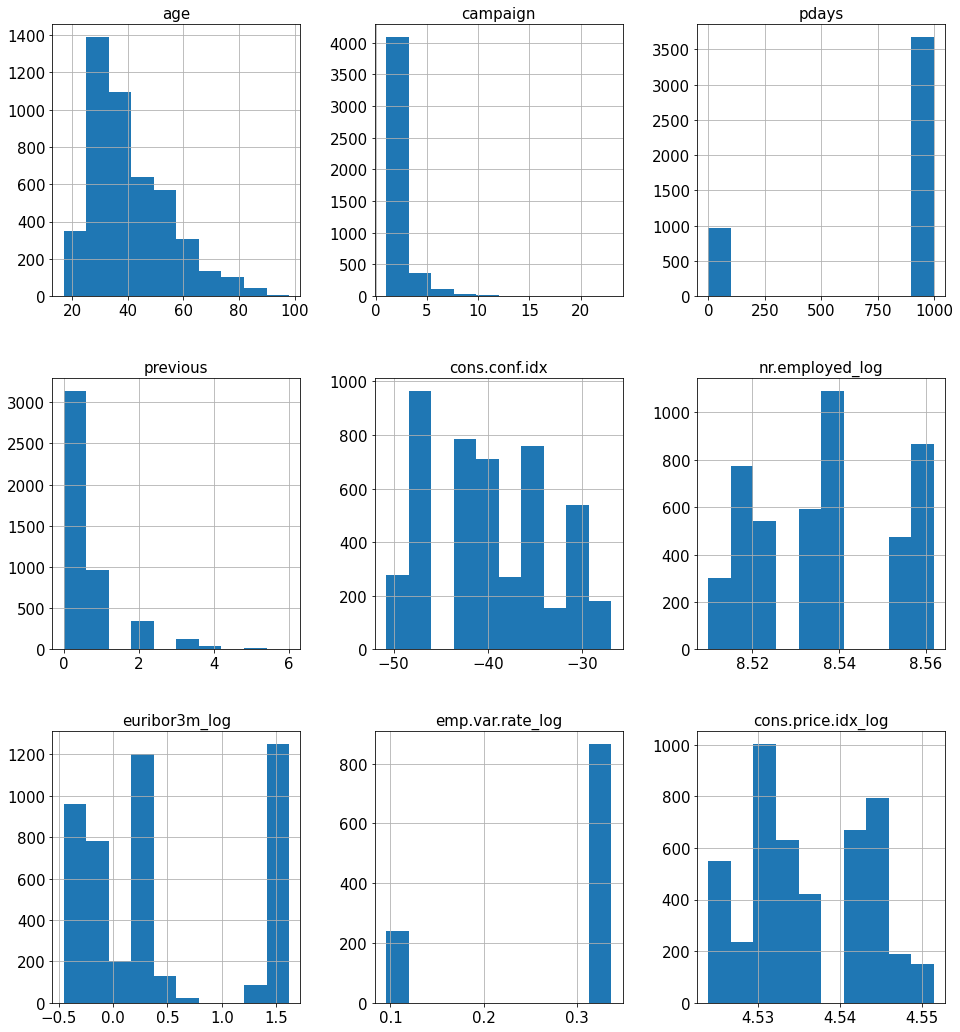

In [40]:
processing_df = df

# Remove - duration as only for benchmark
processing_df = processing_df.drop('duration', 1)
# processing_df['previously_contacted'] = processing_df.pdays.apply(lambda x: 0 if x == 999 else 1)
# processing_df = processing_df.drop('pdays', 1)

# processing_df['pdays_log'] = np.log(processing_df['pdays'])
# processing_df = processing_df.drop('pdays', axis=1)
processing_df['nr.employed_log'] = np.log(processing_df['nr.employed'])
processing_df = processing_df.drop('nr.employed', axis=1)
processing_df['euribor3m_log'] = np.log(processing_df['euribor3m'])
processing_df = processing_df.drop('euribor3m', axis=1)
processing_df['emp.var.rate_log'] = np.log(processing_df['emp.var.rate'])
processing_df = processing_df.drop('emp.var.rate', axis=1)
processing_df['cons.price.idx_log'] = np.log(processing_df['cons.price.idx'])
processing_df = processing_df.drop('cons.price.idx', axis=1)

print(processing_df.head(5))
processing_df.groupby('target').hist(figsize = (16,18))

In [41]:
categorical_columns = ["job","housing", "marital","education","default","loan","contact","month","day_of_week","poutcome"]

for column in categorical_columns:
    tempdf = pd.get_dummies(processing_df[column], prefix=column)
    processing_df = pd.merge(
        left=processing_df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    processing_df = processing_df.drop(columns=column)

# print(processing_df.info())
# processing_df.groupby('target').hist(figsize = (16,18))

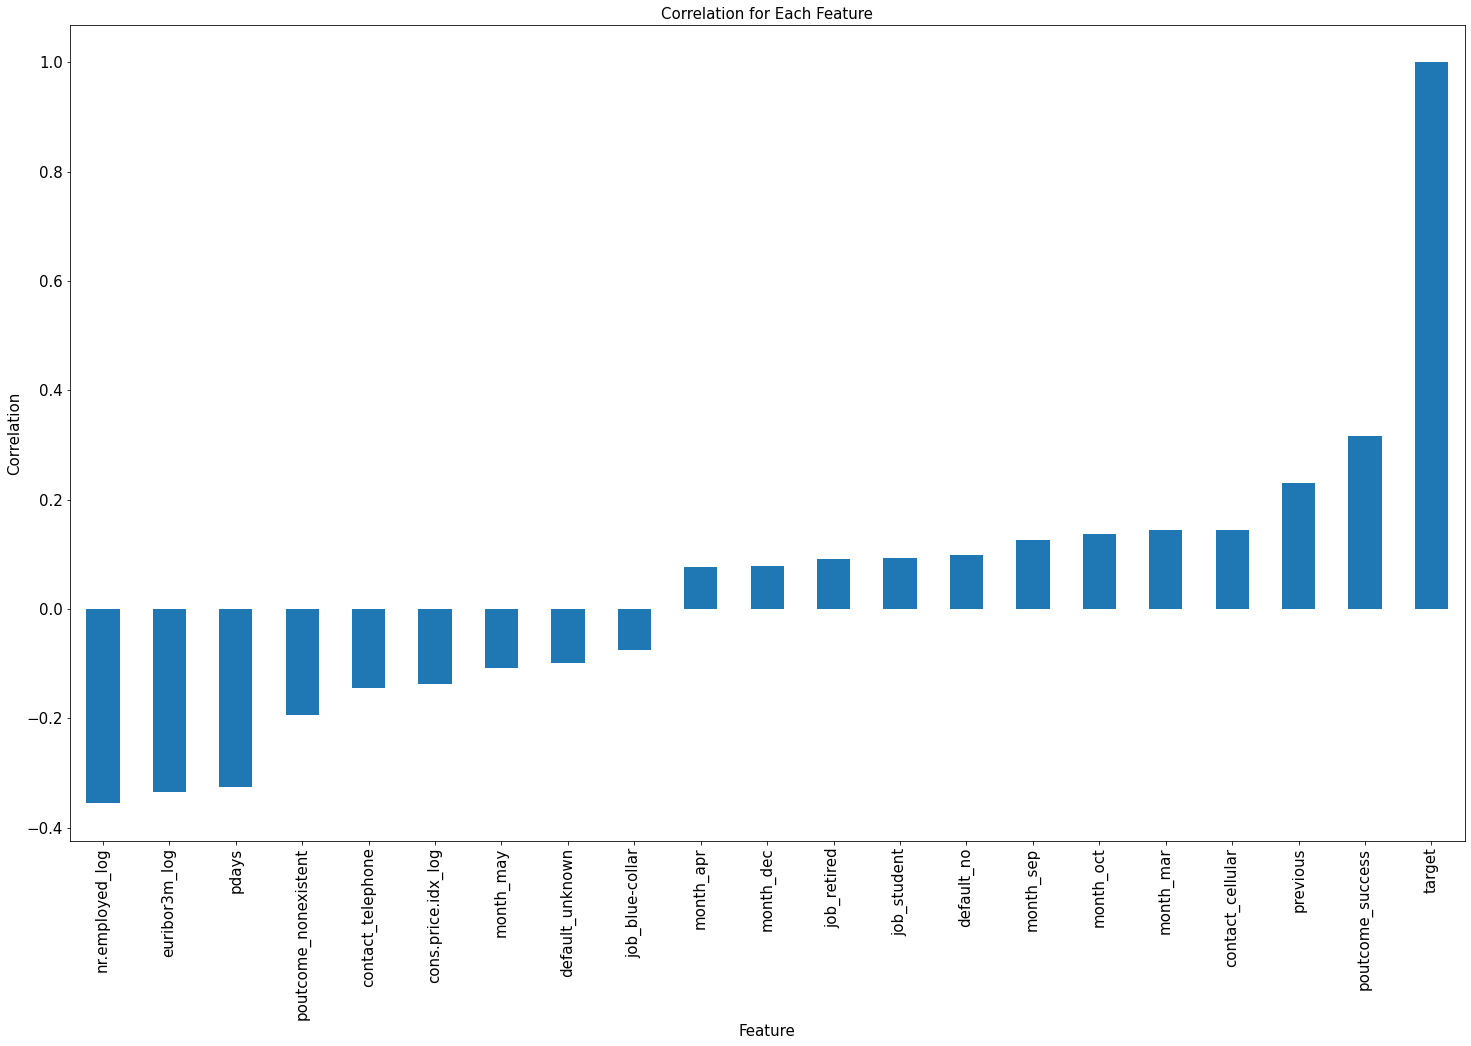

In [42]:
# # Create correlation matrix
std_features_keep = processing_df
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.07

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

# Metrics

In [43]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [44]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))
  return cm

def plot_cm(labels, predictions, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [45]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

## Neural Network

In [46]:
BATCH_SIZE = 2048


import keras
from keras import backend as K
import tensorflow as tf
from keras import layers

# 0.01, 0.001, or 0.0001
learning_rate_intial = 0.001

def build_model(train_data,learning_rate,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  network = keras.Sequential()
  # Add a dropout layer for input layer
  network.add(layers.Dropout(0.2, input_shape=(train_data.shape[-1],)))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid",bias_initializer=output_bias))

  network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return network

# Split Training and Test Data

In [47]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop("target", axis=1)
print(X.head(5))
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

   pdays  previous  ...  poutcome_nonexistent  poutcome_success
0    999         0  ...                     1                 0
1    999         0  ...                     1                 0
2    999         0  ...                     1                 0
3    999         0  ...                     1                 0
4    999         0  ...                     1                 0

[5 rows x 20 columns]
Mean: 0
Standard deviation: 0.9999999999999999


# Plain Model

In [48]:
plain_model = build_model(X_train, learning_rate_intial)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="prc", patience=20),
ModelCheckpoint(filepath="best_model.h5", monitor="prc", save_best_only=True)]
history_weighted = plain_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True)



Epoch 1/100
20/20 [==============================] - 5s 98ms/step - loss: 0.8480 - tp: 2533.0000 - fp: 19448.0000 - tn: 15277.0000 - fn: 1870.0000 - accuracy: 0.4552 - precision: 0.1152 - recall: 0.5753 - auc: 0.5175 - prc: 0.1300 - val_loss: 0.6109 - val_tp: 127.0000 - val_fp: 538.0000 - val_tn: 1285.0000 - val_fn: 110.0000 - val_accuracy: 0.6854 - val_precision: 0.1910 - val_recall: 0.5359 - val_auc: 0.6321 - val_prc: 0.1568
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6860 - tp: 1901.0000 - fp: 13539.0000 - tn: 21186.0000 - fn: 2502.0000 - accuracy: 0.5900 - precision: 0.1231 - recall: 0.4318 - auc: 0.5304 - prc: 0.1328 - val_loss: 0.4739 - val_tp: 65.0000 - val_fp: 286.0000 - val_tn: 1537.0000 - val_fn: 172.0000 - val_accuracy: 0.7777 - val_precision: 0.1852 - val_recall: 0.2743 - val_auc: 0.6512 - val_prc: 0.1665
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6040 - tp: 1471.0000 - fp: 9837.0000 - tn: 24888.0000 - fn: 2932.

loss :  0.29299911856651306
tp :  64.0
fp :  48.0
tn :  1775.0
fn :  173.0
accuracy :  0.8927184343338013
precision :  0.5714285969734192
recall :  0.27004218101501465
auc :  0.7855750918388367
prc :  0.4189506471157074
f1 score: 0.36676217765042973

% right for no:  0.9736697750959956
% right for yes:  0.270042194092827


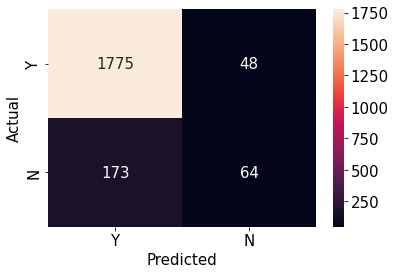

In [49]:
evaluation_results = plain_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = plain_model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(plain_model, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Weighted model

In [50]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = ((1 / no_claim_count) * (total_count) / 2.0 )
weight_claim = (((1 / claim_count) * (total_count) / 2.0 )) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [51]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

initial_bias = np.log([claim/no_claim])
model_weighted = build_model(X_train, learning_rate_intial, initial_bias)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="prc", patience=20),
ModelCheckpoint(filepath="best_model.h5", monitor="prc", save_best_only=True)]
history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/100
20/20 [==============================] - 4s 67ms/step - loss: 1.2047 - tp: 675.0000 - fp: 1945.0000 - tn: 34603.0000 - fn: 3965.0000 - accuracy: 0.8565 - precision: 0.2576 - recall: 0.1455 - auc: 0.5381 - prc: 0.1682 - val_loss: 0.3399 - val_tp: 16.0000 - val_fp: 19.0000 - val_tn: 1804.0000 - val_fn: 221.0000 - val_accuracy: 0.8835 - val_precision: 0.4571 - val_recall: 0.0675 - val_auc: 0.7113 - val_prc: 0.2848
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 1.0340 - tp: 928.0000 - fp: 3070.0000 - tn: 31655.0000 - fn: 3475.0000 - accuracy: 0.8327 - precision: 0.2321 - recall: 0.2108 - auc: 0.5549 - prc: 0.1797 - val_loss: 0.3576 - val_tp: 33.0000 - val_fp: 53.0000 - val_tn: 1770.0000 - val_fn: 204.0000 - val_accuracy: 0.8752 - val_precision: 0.3837 - val_recall: 0.1392 - val_auc: 0.7435 - val_prc: 0.3096
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.9499 - tp: 1162.0000 - fp: 4214.0000 - tn: 30511.0000 - fn: 3241.0000 - 

Evaluation

loss :  0.4578687846660614
tp :  135.0
fp :  197.0
tn :  1626.0
fn :  102.0
accuracy :  0.8548543453216553
precision :  0.40662649273872375
recall :  0.5696202516555786
auc :  0.7856804132461548
prc :  0.4237014949321747
f1 score: 0.4745166959578207

% right for no:  0.8919363686231486
% right for yes:  0.569620253164557


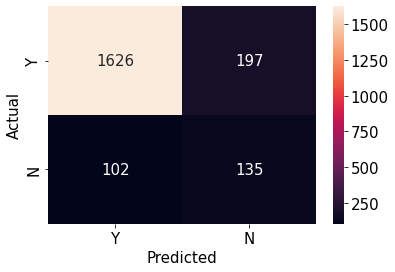

In [52]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Resampling

In [53]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=1.0);
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

No claim Resampled 34725
Claim Resampled 34725
Claim Resampled proportion 50.0%


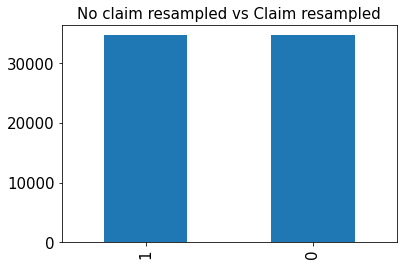

In [54]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

no_claim_resampled, claim_resampled = y_train_resampled.value_counts()
print(f'No claim Resampled {no_claim_resampled}')
print(f'Claim Resampled {claim_resampled}')
print(f'Claim Resampled proportion {round(percentage(claim_resampled, claim_resampled + no_claim_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="No claim resampled vs Claim resampled");

In [55]:
model_resampled = build_model(X_train_resampled, learning_rate_intial)

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="prc", patience=20),
ModelCheckpoint(filepath="best_model.h5", monitor="prc", save_best_only=True)]
history_weighted = model_resampled.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
)

Epoch 1/100
34/34 [==============================] - 3s 40ms/step - loss: 0.8189 - tp: 25678.0000 - fp: 23308.0000 - tn: 13240.0000 - fn: 9284.0000 - accuracy: 0.5442 - precision: 0.5242 - recall: 0.7345 - auc: 0.5913 - prc: 0.6049 - val_loss: 0.6946 - val_tp: 186.0000 - val_fp: 787.0000 - val_tn: 1036.0000 - val_fn: 51.0000 - val_accuracy: 0.5932 - val_precision: 0.1912 - val_recall: 0.7848 - val_auc: 0.7573 - val_prc: 0.3684
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7269 - tp: 25093.0000 - fp: 20190.0000 - tn: 14535.0000 - fn: 9632.0000 - accuracy: 0.5706 - precision: 0.5541 - recall: 0.7226 - auc: 0.6210 - prc: 0.6435 - val_loss: 0.6526 - val_tp: 179.0000 - val_fp: 647.0000 - val_tn: 1176.0000 - val_fn: 58.0000 - val_accuracy: 0.6578 - val_precision: 0.2167 - val_recall: 0.7553 - val_auc: 0.7664 - val_prc: 0.3718
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 0.6858 - tp: 25171.0000 - fp: 18842.0000 - tn: 15883.0000 - fn: 95

loss :  0.5450823307037354
tp :  147.0
fp :  286.0
tn :  1537.0
fn :  90.0
accuracy :  0.8174757361412048
precision :  0.33949190378189087
recall :  0.6202531456947327
auc :  0.7873932123184204
prc :  0.44139498472213745
f1 score: 0.4388059701492537

% right for no:  0.8431157432803071
% right for yes:  0.620253164556962


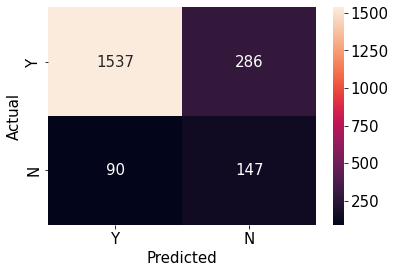

In [56]:
evaluation_results = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_resampled, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Tuning Hyperparamters

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [ ]:
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras # importing keras

def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  network = keras.Sequential()
  # Add a dropout layer for input layer
  network.add(layers.Dropout(0.2, input_shape=(X_train_resampled.shape[-1],)))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=hp_units, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid"))

  network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )
  return network

tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective=kt.Objective("val_prc", direction="max"), # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir3', # directory to save logs 
project_name='khyperband')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# Perform hypertuning
tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_test, y_test))

Trial 30 Complete [00h 01m 10s]
val_prc: 0.46545833349227905

Best val_prc So Far: 0.4785394072532654
Total elapsed time: 00h 18m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
# Build the model with the optimal hyperparameters and train it on the data for N epochs

h_history = h_model.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test, y_test))

val_auc_per_epoch = h_history.history['val_prc']

best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
2171/2171 [==============================] - 21s 8ms/step - loss: 0.5906 - tp: 21517.0000 - fp: 7770.0000 - tn: 28778.0000 - fn: 13445.0000 - accuracy: 0.7033 - precision: 0.7347 - recall: 0.6154 - auc: 0.7543 - prc: 0.7624 - val_loss: 0.5488 - val_tp: 151.0000 - val_fp: 293.0000 - val_tn: 1530.0000 - val_fn: 86.0000 - val_accuracy: 0.8160 - val_precision: 0.3401 - val_recall: 0.6371 - val_auc: 0.7779 - val_prc: 0.4593
Epoch 2/20
2171/2171 [==============================] - 10s 5ms/step - loss: 0.5723 - tp: 21203.0000 - fp: 5661.0000 - tn: 29064.0000 - fn: 13522.0000 - accuracy: 0.7238 - precision: 0.7893 - recall: 0.6106 - auc: 0.7701 - prc: 0.7839 - val_loss: 0.5515 - val_tp: 147.0000 - val_fp: 271.0000 - val_tn: 1552.0000 - val_fn: 90.0000 - val_accuracy: 0.8248 - val_precision: 0.3517 - val_recall: 0.6203 - val_auc: 0.7818 - val_prc: 0.4592
Epoch 3/20
2171/2171 [==============================] - 6s 3ms/step - loss: 0.5661 - tp: 21150.0000 - fp: 5468.0000 - tn: 29257.0000

In [ ]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hp)

# Retrain the model
hypermodel.fit(X_train_resampled, y_train_resampled, epochs=best_epoch, validation_data=(X_test, y_test))

Epoch 1/16
2171/2171 [==============================] - 11s 4ms/step - loss: 0.5889 - tp: 21715.0000 - fp: 7551.0000 - tn: 28997.0000 - fn: 13247.0000 - accuracy: 0.7092 - precision: 0.7420 - recall: 0.6211 - auc: 0.7572 - prc: 0.7639 - val_loss: 0.5527 - val_tp: 148.0000 - val_fp: 288.0000 - val_tn: 1535.0000 - val_fn: 89.0000 - val_accuracy: 0.8170 - val_precision: 0.3394 - val_recall: 0.6245 - val_auc: 0.7787 - val_prc: 0.4621
Epoch 2/16
2171/2171 [==============================] - 7s 3ms/step - loss: 0.5723 - tp: 21343.0000 - fp: 5842.0000 - tn: 28883.0000 - fn: 13382.0000 - accuracy: 0.7232 - precision: 0.7851 - recall: 0.6146 - auc: 0.7706 - prc: 0.7840 - val_loss: 0.5445 - val_tp: 147.0000 - val_fp: 272.0000 - val_tn: 1551.0000 - val_fn: 90.0000 - val_accuracy: 0.8243 - val_precision: 0.3508 - val_recall: 0.6203 - val_auc: 0.7812 - val_prc: 0.4517
Epoch 3/16
2171/2171 [==============================] - 6s 3ms/step - loss: 0.5653 - tp: 21345.0000 - fp: 5532.0000 - tn: 29193.0000 

best epoch:  16
loss :  0.5227481126785278
tp :  145.0
fp :  243.0
tn :  1580.0
fn :  92.0
accuracy :  0.8373786211013794
precision :  0.37371134757995605
recall :  0.6118143200874329
auc :  0.7903997898101807
prc :  0.46949249505996704
f1 score: 0.44844517184942717

% right for no:  0.8699945145364784
% right for yes:  0.5780590717299579


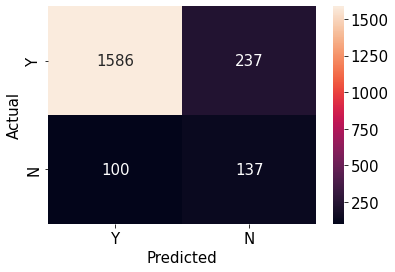

In [ ]:
print("best epoch:  " + str(best_epoch))
evaluation_results = h_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(h_model, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Architecture

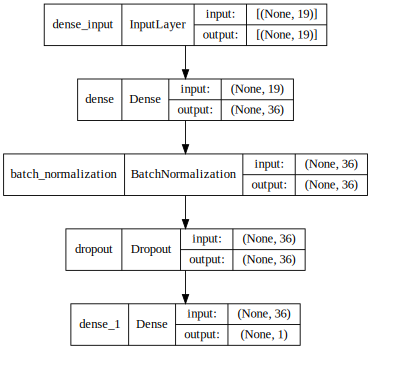

In [ ]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))